# LEVERAGING PRE-TRAINED MODELS

In [1]:
import numpy as np
import sklearn
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
CONFIGURATION = {
    "CLASS_NAMES" : ['angry', 'happy', 'sad'],
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : 256,
    "LEARNING_RATE" : 0.01,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 3
}

trainDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/train"
testDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/test"

trainDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='validation',
)

testDataset = tf.keras.utils.image_dataset_from_directory(
    testDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=None,
    subset=None,
)

trainDataset = trainDataset.prefetch(tf.data.AUTOTUNE)
testDataset = testDataset.prefetch(tf.data.AUTOTUNE)
valDataset = valDataset.prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.
Using 5440 files for training.
Found 6799 files belonging to 3 classes.
Using 1359 files for validation.
Found 2278 files belonging to 3 classes.


2025-01-30 14:36:01.112754: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-30 14:36:01.112781: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-01-30 14:36:01.112788: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-01-30 14:36:01.112802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-30 14:36:01.112811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading Pre-Trained Efficient Net B4 Model

In [3]:
# Loading Pre-Trained Efficient Net B4 Model trained on ImageNet Dataset
backbone = tf.keras.applications.EfficientNetB4(
    include_top = False, # Include Classifier or Not
    weights = 'imagenet',
    input_shape = (CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"], 3)
)

In [4]:
# Freezing The Model Weights so That They Do Not Update
backbone.trainable = False

## Defining Classification Model Using Pre-Trained Model as Feature Extractor

In [5]:
# Resize-Rescale Layer will be added to Model itself for easy deployment
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, None, 3)),
    backbone, # Feature Extractor Part of Model
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(CONFIGURATION['N_DENSE_2'], activation='relu'),
    tf.keras.layers.Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, None, None,     │    17,673,823 │
│                                 │ 1792)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

## Training on Small Dataset 

In [6]:
lossFunction = tf.keras.losses.CategoricalCrossentropy()
METRICS = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss = lossFunction,
    metrics=METRICS
)

In [8]:
history = model.fit(
    trainDataset.take(10), # Training on a small dataset
    validation_data = valDataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose=1,
)

Epoch 1/20


2025-01-30 14:36:05.844678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4474 - loss: 7.3127 - top_k_accuracy: 0.8238 - val_accuracy: 0.5408 - val_loss: 13.7860 - val_top_k_accuracy: 0.8182
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6062 - loss: 5.2537 - top_k_accuracy: 0.8522 - val_accuracy: 0.5092 - val_loss: 21.7497 - val_top_k_accuracy: 0.7962
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6600 - loss: 3.5595 - top_k_accuracy: 0.8466 - val_accuracy: 0.4709 - val_loss: 24.7348 - val_top_k_accuracy: 0.8035
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6299 - loss: 3.0457 - top_k_accuracy: 0.8353 - val_accuracy: 0.5357 - val_loss: 10.1521 - val_top_k_accuracy: 0.7800
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6529 - loss: 1.8220 - top_k_accuracy: 0.8722 - val_accuracy: 0.5239 - val_loss: 6.4534 - val_top_k_accuracy: 0.7866
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5999 - loss: 2.2312 - top_k_accuracy: 0.883

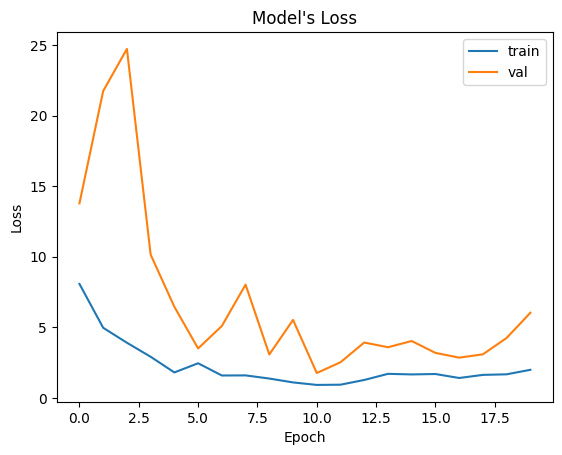

In [9]:
# PLotting the model's loss graph for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

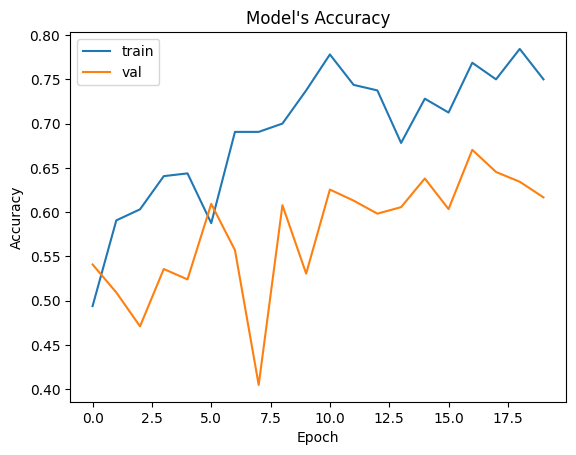

In [10]:
# PLotting the model's accuracy graph for both training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

## Evaluation

In [11]:
model.evaluate(testDataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - accuracy: 0.6495 - loss: 5.8805 - top_k_accuracy: 0.8571


[5.6900506019592285, 0.6549605131149292, 0.8674275875091553]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2025-01-30 14:42:24.093813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


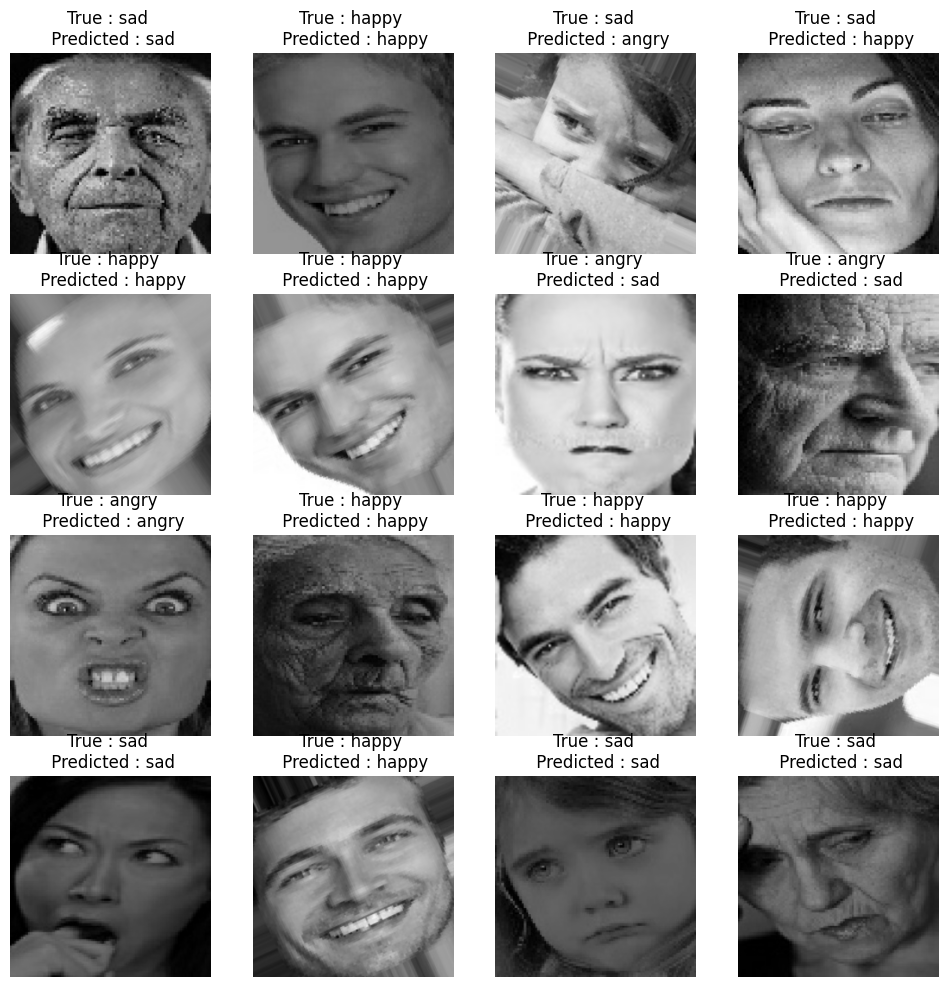

In [12]:
# Testing 1 Batch
plt.figure(figsize=(12, 12))

for images, labels in testDataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        prediction = model.predict(tf.expand_dims(images[i], axis=0))
        true = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()]
        predicted = CONFIGURATION["CLASS_NAMES"][tf.argmax(prediction, axis=-1).numpy()[0]]
        plt.title("True : {} \n Predicted : {}".format(true, predicted))
        plt.axis("off")

## Confusion Matrix

[2 1 2 ... 1 0 1] [0 1 2 ... 1 0 0]
[[144  62  89]
 [ 60 435 107]
 [ 99 100 248]]


2025-01-30 14:42:44.519389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0.5, 36.72222222222221, 'Predicted')

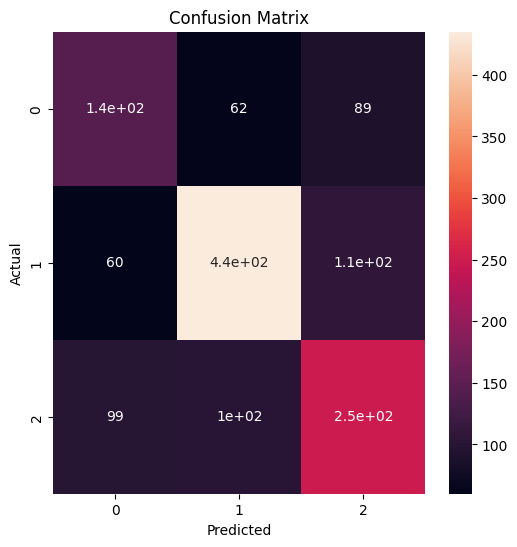

In [13]:
labels = []
predicted = []
for image, label in valDataset:
    predicted.append(model.predict(image, verbose=0))
    labels.append(label.numpy())

pred = np.argmax(predicted[:-1], axis=-1).flatten()
true = np.argmax(labels[:-1], axis=-1).flatten()
print(pred, true)

cm = sklearn.metrics.confusion_matrix(true, pred)
print(cm)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')